# Data import



In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark import RDD
from pyspark import SparkContext
#sc = SparkContext(appName='notebook')
%load_ext autoreload
%autoreload 2
import src.correlations as correlations
import src.analysis_functions as analysis_functions
import src.graphing_functions as graphing_functions
import src.pitch_analysis as pitch_analysis
import src.feature_viz_util as feat_util
from src.analysis_functions import is_numeric
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_DIR = 'data/'

music_brainz_rdd = sc.pickleFile(DATA_DIR + 'musicbrainz-songs')
analysis_songs_rdd = sc.pickleFile(DATA_DIR + 'analysis-songs')
metadata_songs_rdd = sc.pickleFile(DATA_DIR + 'metadata-songs')
analysis_segments_timbre = sc.pickleFile(DATA_DIR + 'analysis-segments_timbre')
analysis_segments_pitch = sc.pickleFile(DATA_DIR + 'analysis-segments_pitches')

# Data analysis
In order to get a better grasp of the characteristics of hit, we compare the features characterizing the songs of each year with the features of the songs ranked as "hot".

The considered features would be :

__analysis-song__

- danceability
- duration
- energy
- key
- loudness
- mode (Maj/min)
- tempo
- time signature (beats per measure)
- pitch analysis

__other files__
- artiste longitude/latitude
- lyrics 
- language
- artist hotness
- genre

The success of each song will be evaluated with the song hotness feature and its ranking in the billboard ranking of summer hits 

https://www.billboard.com/articles/news/513524/summer-songs-1985-present-top-10-tunes-each-summer-listen



# Loading and Managing the data
With 280Go of data, and knowing the cluster has 252Go of ram, it is clear we cannot load the whole dataset in one RDD. Even if the RDD has a more compressed representation than the original data, some processing space is also needed. We decided to use a column store style approach. The h5py files each contain the following elements:

* analysis.bars_confidence
* analysis.bars_start
* analysis.beats_confidence
* analysis.beats_start
* analysis.sections_confidence
* analysis.sections_start
* analysis.segments_confidence
* analysis.segments_loudness_max
* analysis.segments_loudness_max_time
* analysis.segments_loudness_start
* analysis.segments_pitches
* analysis.segments_start
* analysis.segments_timbre
* analysis.songs
* analysis.tatums_confidence
* analysis.tatums_start
* metadata.artist_terms
* metadata.artist_terms_freq
* metadata.artist_terms_weight
* metadata.similar_artists
* metadata.songs
* musicbrainz.artist_mbtags
* musicbrainz.artist_mbtags_count
* musicbrainz.songs

We extracted each element separately and stored them in keyed RDDs (file_id, data). The two biggest elements are `analysis.segments_pitches` and `analysis.segments_timbre`. They each take 26% of the data size, so the maximum size an RDD can take is 72Go of ram space. Now we can load each RDD individually. If we need multiple elements simultaniously we can join the RDDs, and if the joined RDDs are two big for the cluster we can do some sampling to reduce the size. Loading each element individually is a lot faster now too. This operation is done in the script `src/extract_rdds_from_data.py`. We have only used the script to work on the data locally yet, but as soon as the whole dataset is uncompressed, we will extract the RDDs from the dataset.

# Feature overview
From the Millonsong documentation, we found that the tracks had been chosen amongst the most "familiar" artists according to The Echo Nest, and some extreme songs according to the features defined by The Echo Nest. To get a grasp of these features, we will plot them by year for the subset.

Some of the features are not define amongst our subset (danceability, energy), so we will not plot them here.

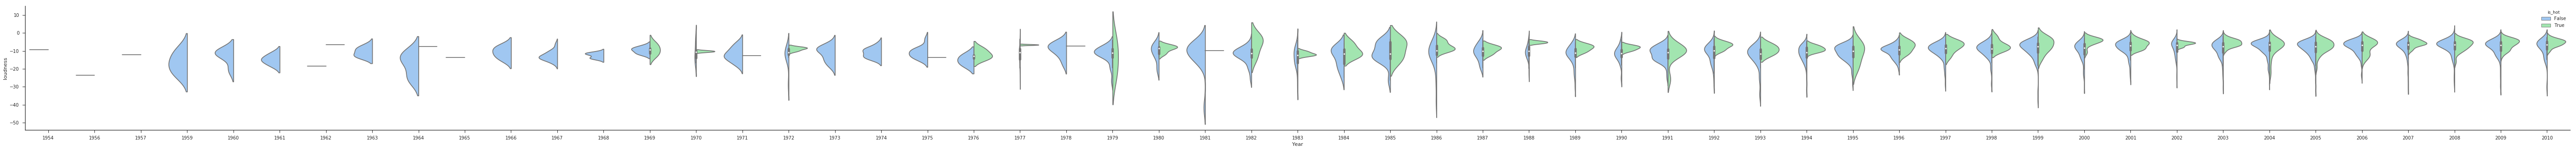

In [26]:
hotness=metadata_songs_rdd.map(lambda x: (x[0], x[1]['song_hotttnesss'][0])).filter(lambda x: is_numeric(x[1]))
year=music_brainz_rdd.map(lambda x: (x[0], x[1]['year'][0])).filter(lambda x: not (int(x[1]) == 0))
feat=analysis_songs_rdd.map(lambda x: (x[0], x[1]['loudness'][0])).filter(lambda x: is_numeric(x[1]))

joined=feat.join(year).join(hotness)
lst=joined.collect()

feat_util.plot_violin(lst,'loudness')

From this plot, we see that the hot songs tend to be a bit louder than average.

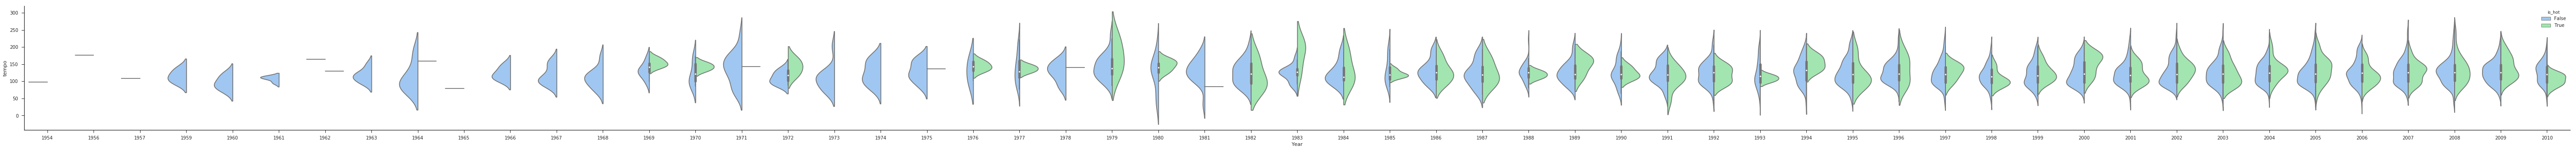

In [22]:
feat=analysis_songs_rdd.map(lambda x: (x[0], x[1]['tempo'][0])).filter(lambda x: is_numeric(x[1]))

joined=feat.join(year).join(hotness)
lst=joined.collect()

feat_util.plot_violin(lst,'tempo')

The tempo is pretty similar for the hot songs and the total. The most frequent range is around 110-130 bpm

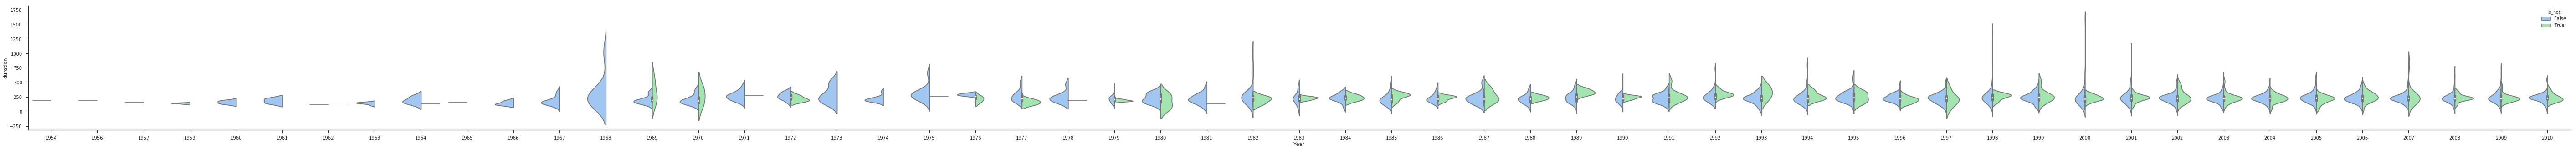

In [23]:
feat=analysis_songs_rdd.map(lambda x: (x[0], x[1]['duration'][0])).filter(lambda x: is_numeric(x[1]))

joined=feat.join(year).join(hotness)
lst=joined.collect()

feat_util.plot_violin(lst,'duration')

As for the tempo, the duration of the hot songs is around the average, and never on the extremes.

In [35]:
df=feat_util.rdd_to_df(analysis_songs_rdd,year,hotness,'key')
s1=feat_util.get_n_most_common(df,'key')
s2=feat_util.get_n_most_common(df[df.Hotness>0.7],'key')
res=pd.concat([s1,s2],axis=1)
res.rename(columns={0:'Overall',1:'Hot songs'},inplace=True)
res.tail(6)

,Overall,Hot songs
Year,,
2005,7.0,1.0
2006,0.0,0.0
2007,7.0,5.0
2008,2.0,1.0
2009,2.0,1.0
2010,7.0,10.0


The most frequent key is different with for the popular songs and the overall.

In [36]:
df=feat_util.rdd_to_df(analysis_songs_rdd,year,hotness,'mode')
s1=feat_util.get_n_most_common(df,'mode')
s2=feat_util.get_n_most_common(df[df.Hotness>0.7],'mode')
res=pd.concat([s1,s2],axis=1)
res.rename(columns={0:'Overall',1:'Hot songs'},inplace=True)
res.tail(6)

,Overall,Hot songs
Year,,
2005,1.0,1.0
2006,1.0,1.0
2007,1.0,0.0
2008,1.0,1.0
2009,1.0,1.0
2010,1.0,1.0


For both, the usual mode is the Major mode.

# Pitch analysis
In pitch analysis, we are trying to extract chords, and chord sequences. The pitches are represented as sequence of [chroma features](https://en.wikipedia.org/wiki/Chroma_feature), so it is a n by 12 matrix.

We start the pitch analysis by looking at the histograms of all the values in the pitch anlysis:

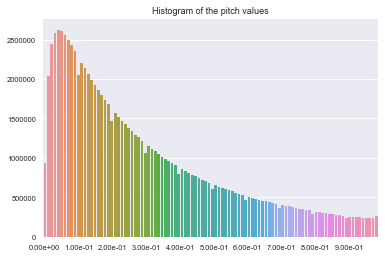

In [8]:
graphing_functions.print_histogram(analysis_functions.numeric_array_or_matrix_histogram(analysis_segments_pitch)[2], title="Histogram of the pitch values")

The histogram gives us a visualization of the kind of values to expect when analysing the pitch. The first approach to analysing the pitch is recovering the most popular chrom features. First we get an rdd of 'hot' songs:

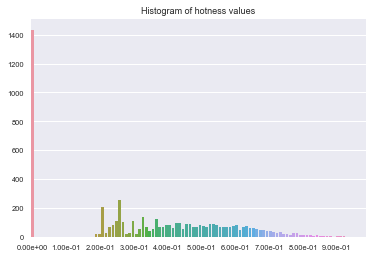

In [9]:
hotness = metadata_songs_rdd.map(lambda x: (x[0], x[1]['song_hotttnesss'][0])).filter(lambda x: analysis_functions.is_numeric(x[1]))
graphing_functions.print_histogram(analysis_functions.get_histogram(hotness.map(lambda x: x[1]))[2], title="Histogram of hotness values")

Looking at the hotness histogram, we can take song for hotness values above 0.5. We don't want to be too strict on the hotness values, or we will not have enough data to work with latter (on the subset we are left with 1713 songs). Hotness value 0 is an indication that the hotness was not included in the data set.

In [10]:
most_hot_pitches = analysis_segments_pitch.join(hotness.filter(lambda x : x[1] > 0.5)).map(lambda x: (x[0], x[1][0]))
most_hot_pitches.count()

1713

For all chroma features we apply a threshold telling us if the pitch should be considered as a note, or not. Looking at histogram of pitch values, 0.7 seems like a raesonable value to use. Now for each song, we extract the three most present chroma feature (with the threshold applied), and then for all the songs, we extract the top chroma features. Bellow, 1's represent where notes are. We get:

In [11]:
pitch_analysis.pretty_print_sequence_list(pitch_analysis.get_most_popular_pitches_from_rdd(most_hot_pitches, threshold=0.7, use_chord_structure=False))

Sequence 0 with 557 occurrences
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 1 with 546 occurrences
(0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 2 with 433 occurrences
(0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0)
()
Sequence 3 with 412 occurrences
(0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 4 with 383 occurrences
(0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0)
()
Sequence 5 with 372 occurrences
(1 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 6 with 356 occurrences
(0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 7 with 339 occurrences
(0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1)
()
Sequence 8 with 263 occurrences
(0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 9 with 225 occurrences
(0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,0)
()


Oouppss, we notice that the chroma features that contain only one single note appear multiple times. We are not interested in what the absolute note is, but rather what kind of chords we can have. For this reason, we apply an extract filter that tries to offset the notes so that chords that are just offsets of one another are considered as the same:

In [12]:
pitch_analysis.pretty_print_sequence_list(pitch_analysis.get_most_popular_pitches_from_rdd(most_hot_pitches, threshold=0.7, use_chord_structure=True))

Sequence 0 with 1712 occurrences
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 1 with 1590 occurrences
(1 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 2 with 569 occurrences
(1 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 3 with 462 occurrences
(1 ,1 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 4 with 392 occurrences
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0)
()
Sequence 5 with 133 occurrences
(1 ,1 ,1 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 6 with 47 occurrences
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0)
()
Sequence 7 with 43 occurrences
(1 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 8 with 42 occurrences
(1 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 9 with 41 occurrences
(1 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()


Sequence 0 is a simple note, nothing surprising, many songs can hold a single note. Sequence 1,3,5 would sound terrible on a instrument, this might be due to the threshold not being set properly. Sequence 2 is tonic - 5 chord, sequence 4 is the seventh and sequence 7 is the major chord.

Now we do the same opperation but by considering consecutive chroma features, in hopes of finding popular song constructions:

In [14]:
pitch_analysis.pretty_print_sequence_list(
    pitch_analysis.get_most_popular_pitches_sequence_from_rdd\
    (most_hot_pitches, 8, top=10, threshold=0.85, top_per_song=3)
)

Sequence 0 with 749 occurrences
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 1 with 35 occurrences
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0)
()
Sequence 2 with 32 occurrences
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
(0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0)
()
Sequence 

This time we used 0.85 as threshold, as it gave better results than 0.7. No nice chord structure seems to be appearing. Supposedly, we should see the famous 4 chords that make most of the popular music. Either the data wasn't chosen correctly, or the processing still needs working on.

# Primary Component Analysis (PCA)

We also tried to do a dimensionality reduction on the compiled features on each song that are given to us in the dataset. The parts that interested us were `metadata-songs` and `analysis-songs`. Sadly in the sample data, some of the computed features were always zero (danceability, energy). We are hoping these will be defined in the real dataset. All of this was done to try and determine the correlation of these datapoints and to see whether they may help in determining the hotness of a song.

Our pipeline was really simple, but sadly does not give any results (only `NaN`s). We wanted to compute the MSE for different values of features `k` in the PCA and plot them to see the amount of features that were of interest.

[Notebook pipeline](./src/PCA_test.ipynb)